# Data generator

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from yolo3.utils import get_random_data
from yolo3.model import preprocess_true_boxes

/Users/chaunguyen/anaconda2/envs/keras/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [3]:
annotation_path = '2012_train.txt'

In [4]:
with open(annotation_path) as f:
    lines = f.readlines()

In [5]:
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

In [6]:
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

input_shape = (416,416) # multiple of 32, hw

## data_generator function

In [7]:
val_split = 0.1
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

annotation_lines = lines[:num_train]

### get_random_data function

In [8]:
i = 1

(375, 500, 3)

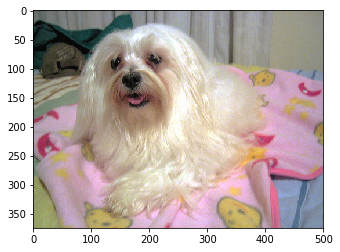

In [9]:
# Original image
annotation_line = annotation_lines[i]
line = annotation_line.split()
image = Image.open(line[0])
box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])

image = np.array(image)
plt.imshow(image)
image.shape

(416, 416, 3)

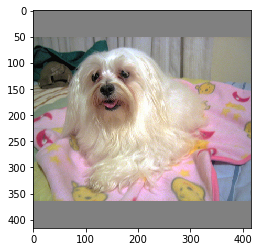

In [160]:
# Image with resizing and padding to become input_shape shape WITHOUT transforming image
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=False)
plt.imshow(image)
image.shape

(416, 416, 3)

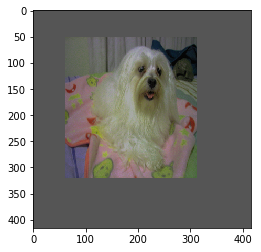

In [159]:
# Randomly Transforming image: resize, transition, flip and distort color
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=True)
plt.imshow(image)
image.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(416, 416, 3)

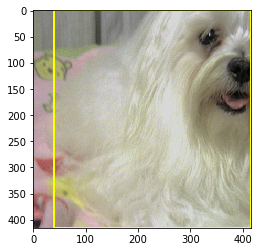

In [13]:
# Draw bounding box
k = 0
x1 = int(box[k][0])
y1 = int(box[k][1])
x2 = int(box[k][2])
y2 = int(box[k][3])

cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

plt.imshow(image)
image.shape

### preprocess_true_boxes function

In [186]:
box_data = []
box[1] = box[0]
box_data.append(box)
box_data = np.array(box_data)

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [187]:
true_boxes = box_data

In [188]:
assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
num_layers = len(anchors)//3 # default setting
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

true_boxes = np.array(true_boxes, dtype='float32')
input_shape = np.array(input_shape, dtype='int32')
# x,y is of center of boxes, w,h is the width and height of boxes
boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
# normalize into image coordinates (0,1)
true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

# number of images in the batch, or batch_size
m = true_boxes.shape[0]
layer2stride = {0:32, 1:16, 2:8}
grid_shapes = [input_shape//layer2stride[l] for l in range(num_layers)]
# initialize y_true for correct output shapes
y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
    dtype='float32') for l in range(num_layers)]

# Expand dim to apply broadcasting.
anchors = np.expand_dims(anchors, 0)
anchor_maxes = anchors / 2.
anchor_mins = -anchor_maxes
valid_mask = boxes_wh[..., 0]>0

In [189]:
anchor_mins

array([[[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-186.5, -163. ]]])

In [190]:
b = 0

# Discard zero rows.
wh = boxes_wh[b, valid_mask[b]]
if len(wh)==0:
    print("len 0")
else:
    # Expand dim to apply broadcasting.
    wh = np.expand_dims(wh, -2)
    box_maxes = wh / 2.
    box_mins = -box_maxes

    intersect_mins = np.maximum(box_mins, anchor_mins)
    intersect_maxes = np.minimum(box_maxes, anchor_maxes)
    intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    box_area = wh[..., 0] * wh[..., 1]
    anchor_area = anchors[..., 0] * anchors[..., 1]
    iou = intersect_area / (box_area + anchor_area - intersect_area)

    # Find best anchor for each true box
    best_anchor = np.argmax(iou, axis=-1)

In [191]:
best_anchor

array([8, 8])

In [192]:
iou

array([[0.00175799, 0.00649105, 0.01026397, 0.02474712, 0.03772922,
        0.0949451 , 0.14118029, 0.41769892, 0.608135  ],
       [0.00175799, 0.00649105, 0.01026397, 0.02474712, 0.03772922,
        0.0949451 , 0.14118029, 0.41769892, 0.608135  ]])

In [193]:
intersect_mins

array([[[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-133. , -139. ]],

       [[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-133. , -139. ]]])

In [194]:
box_mins

array([[[-133., -139.]],

       [[-133., -139.]]], dtype=float32)

In [195]:
anchor_mins

array([[[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-186.5, -163. ]]])

In [196]:
anchors

array([[[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.],
        [ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.],
        [116.,  90.],
        [156., 198.],
        [373., 326.]]])

In [197]:
anchor_maxes

array([[[  5. ,   6.5],
        [  8. ,  15. ],
        [ 16.5,  11.5],
        [ 15. ,  30.5],
        [ 31. ,  22.5],
        [ 29.5,  59.5],
        [ 58. ,  45. ],
        [ 78. ,  99. ],
        [186.5, 163. ]]])

In [198]:
anchor_mins

array([[[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-186.5, -163. ]]])

In [199]:
valid_mask

array([[ True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]])

In [200]:
wh

array([[[266., 278.]],

       [[266., 278.]]], dtype=float32)

In [201]:
box_maxes

array([[[133., 139.]],

       [[133., 139.]]], dtype=float32)

In [202]:
box_mins

array([[[-133., -139.]],

       [[-133., -139.]]], dtype=float32)

In [203]:
intersect_mins

array([[[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-133. , -139. ]],

       [[  -5. ,   -6.5],
        [  -8. ,  -15. ],
        [ -16.5,  -11.5],
        [ -15. ,  -30.5],
        [ -31. ,  -22.5],
        [ -29.5,  -59.5],
        [ -58. ,  -45. ],
        [ -78. ,  -99. ],
        [-133. , -139. ]]])

In [204]:
intersect_maxes

array([[[  5. ,   6.5],
        [  8. ,  15. ],
        [ 16.5,  11.5],
        [ 15. ,  30.5],
        [ 31. ,  22.5],
        [ 29.5,  59.5],
        [ 58. ,  45. ],
        [ 78. ,  99. ],
        [133. , 139. ]],

       [[  5. ,   6.5],
        [  8. ,  15. ],
        [ 16.5,  11.5],
        [ 15. ,  30.5],
        [ 31. ,  22.5],
        [ 29.5,  59.5],
        [ 58. ,  45. ],
        [ 78. ,  99. ],
        [133. , 139. ]]])

In [205]:
intersect_wh

array([[[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.],
        [ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.],
        [116.,  90.],
        [156., 198.],
        [266., 278.]],

       [[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.],
        [ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.],
        [116.,  90.],
        [156., 198.],
        [266., 278.]]])

In [206]:
anchors

array([[[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.],
        [ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.],
        [116.,  90.],
        [156., 198.],
        [373., 326.]]])

In [207]:
intersect_area

array([[  130.,   480.,   759.,  1830.,  2790.,  7021., 10440., 30888.,
        73948.],
       [  130.,   480.,   759.,  1830.,  2790.,  7021., 10440., 30888.,
        73948.]])

In [208]:
box_area

array([[73948.],
       [73948.]], dtype=float32)

In [209]:
best_anchor

array([8, 8])

In [210]:
for t, n in enumerate(best_anchor):
    print(t, n)

0 8
1 8


In [211]:
grid_shapes

[array([13, 13], dtype=int32),
 array([26, 26], dtype=int32),
 array([52, 52], dtype=int32)]

In [212]:
true_boxes

array([[[ 0.46634614,  0.50721157,  0.6394231 ,  0.6682692 ,
         11.        ],
        [ 0.46634614,  0.50721157,  0.6394231 ,  0.6682692 ,
         11.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.   

In [215]:
anchor_mask[0].index(8)

2

In [217]:
true_boxes[0,0,4]

11.0

In [218]:
true_boxes[0,0,0:4]

array([0.46634614, 0.50721157, 0.6394231 , 0.6682692 ], dtype=float32)